In [35]:
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

In [46]:
plt.rcParams["figure.figsize"] = (16, 12)

The data represented hereare the reuslt of a ~ 16-year effort to generate a vegetation map of Joshua Tree NP (https://irma.nps.gov/DataStore/Reference/Profile/2233319):

```
Inc. (AIS) out of Redlands, CA. The mapping effort began in 1996 and by 2004 they had produced a vegetation map (referred to as the 2005 version of the map), along with two reports (see Appendix F and G) titled, Photo-Interpretation Report, USGS-NPS Vegetation and Inventory and Mapping Program, Joshua Tree National Park and USGS-NPS Vegetation Mapping Program, Joshua Tree National Park Mapping Classification. AIS was hired again in 2009-2010 to assist in updating the map; they hosted the meeting in August 2009, then proceeded to make changes to the map as discussed at the meeting. For the most part, this involved revisiting aerial photos and reevaluating the map class assigned to each problematic polygon, as well as correcting any global recodes and minor edits to the nomenclature. Aerial imagery used for the project was from 1998, including the revisits in 2009, and the minimum mapping unit was defined as 0.50 hectares. For more detail on methods used by AIS to produce the map and a summary of the project pre-2005, refer to the reports mentioned above.
```

Due to the differing survey methodologies (ground surveys vs aerial photographs), there were discrepancies between land classifications outline here in the 'Accuracy Assessment Contigency Table' (https://irma.nps.gov/DataStore/Reference/Profile/2215775)

A report was created outlining the creation of this vegation map, as well (https://irma.nps.gov/DataStore/Reference/Profile/2215775)

![](jotrgeodata/JOTR%20GDB%20Diagram.jpg)

In [36]:
fiona.listlayers("jotrgeodata/jotrgeodata.gdb")

['JOTR_VegPoints',
 'JOTR_xPlants_lu',
 'JOTR_Park_Boundary',
 'JOTR_tSpecies',
 'JOTR_VegPolys',
 'JOTR_xMapUnit_lu',
 'JOTR_tVegMapInfo',
 'JOTR_tMapUnit_NVCS2',
 'JOTR_xCoverClass_lu',
 'JOTR_xLandform_lu',
 'JOTR_xPhysio_Class_lu',
 'JOTR_xStratum_lu',
 'JOTR_xSurficial_Geology_lu',
 'JOTR_tProjectMetadata',
 'JOTR_tAAEventSpecies',
 'JOTR_tAAEvents',
 'JOTR_tPhotos',
 'JOTR_tPlotEventSpecies',
 'JOTR_tAA_tPlots',
 'JOTR_tPlotEvents',
 'JOTR_x2005_2012_documentation',
 'JOTR_tQuickplots']

For viz purposes, we will grab the park boundary:


In [37]:
park_boundary = gpd.read_file("jotrgeodata/jotrgeodata.gdb", layer="JOTR_Park_Boundary")

For our initial purposes, we are interested primarily in the Veg polygon, we we will grab `JOTR_VegPolys`:

In [38]:
veg_poly = gpd.read_file("jotrgeodata/jotrgeodata.gdb", layer="JOTR_VegPolys")

In [39]:
veg_poly.head()

,Poly_ID,MapUnit_ID,MapUnit_Name,X_Centroid,Y_Centroid,Acres,Hectares,SHAPE_Length,SHAPE_Area,geometry
0,1,10025,California Juniper / Blackbush Woodland Associ...,576114.408632,3.758601e+06,4.703791,1.903557,544.379601,19035.568321,"MULTIPOLYGON (((576099.841 3758532.400, 576084..."
1,2,27031,Creosote Bush - White Bursage Shrubland Associ...,592453.473849,3.750564e+06,2.077488,0.840730,401.724504,8407.297678,"MULTIPOLYGON (((592520.591 3750558.295, 592519..."
2,3,27034,Creosote Bush - White Bursage - White Rhatany ...,656492.468889,3.765693e+06,3.485286,1.410445,1279.356090,14104.450027,"MULTIPOLYGON (((656685.514 3765864.966, 656679..."
3,4,27034,Creosote Bush - White Bursage - White Rhatany ...,656720.121932,3.765627e+06,6.357370,2.572736,1995.108688,25727.362693,"MULTIPOLYGON (((656926.234 3765840.206, 656920..."
4,5,27045,Creosote Bush - White Bursage - Mojave Yucca S...,609388.031467,3.733959e+06,235.720562,95.392727,6848.340282,953927.271781,"MULTIPOLYGON (((609325.760 3734554.420, 609259..."


In [48]:
veg_poly.MapUnit_Name.unique()

array(['California Juniper / Blackbush Woodland Association',
       'Creosote Bush - White Bursage Shrubland Association',
       'Creosote Bush - White Bursage - White Rhatany Shrubland Association',
       'Creosote Bush - White Bursage - Mojave Yucca Shrubland Association',
       'Creosote Bush - Brittlebush - White Bursage Shrubland Association',
       'Blackbush - Nevada Ephedra Shrubland Association',
       'Big Galleta / White Bursage Herbaceous Association',
       'Big Galleta / Four-Wing Saltbush Herbaceous Association',
       'Non-vegetated Habitat (less than 2% absolute cover)',
       'Joshua Tree / Blackbush Woodland Association',
       'Joshua Tree / Creosote Bush - Mojave Yucca / Big Galleta Woodland Association',
       'Desert Twinbugs - Desert Sand Verbena Sparsely Vegetated Alliance (Desert Dunes and Sand Flats)',
       'Creosote Bush - Desert Holly Shrubland Association',
       'Creosote Bush - White Bursage - Jojoba Shrubland Association',
       'Creosote

In [40]:
[
    map_unit_name
    for map_unit_name in veg_poly.MapUnit_Name.unique()
    if "Joshua Tree" in map_unit_name
]

['Joshua Tree / Blackbush Woodland Association',
 'Joshua Tree / Creosote Bush - Mojave Yucca / Big Galleta Woodland Association',
 'Joshua Tree - California Juniper / Nevada Ephedra Woodland Association',
 'Joshua Tree Woodland Alliance',
 'Joshua Tree / Big Galleta Woodland Association',
 'Joshua Tree / Desert Almond Woodland Association']

Let's engineer a feature for any MapUnit_Name that contains any Joshua Trees:

In [41]:
veg_poly.loc[:, "contains_Joshua_Tree"] = [
    True if "Joshua Tree" in map_unit_name else False
    for map_unit_name in veg_poly.MapUnit_Name
]

<Axes: >

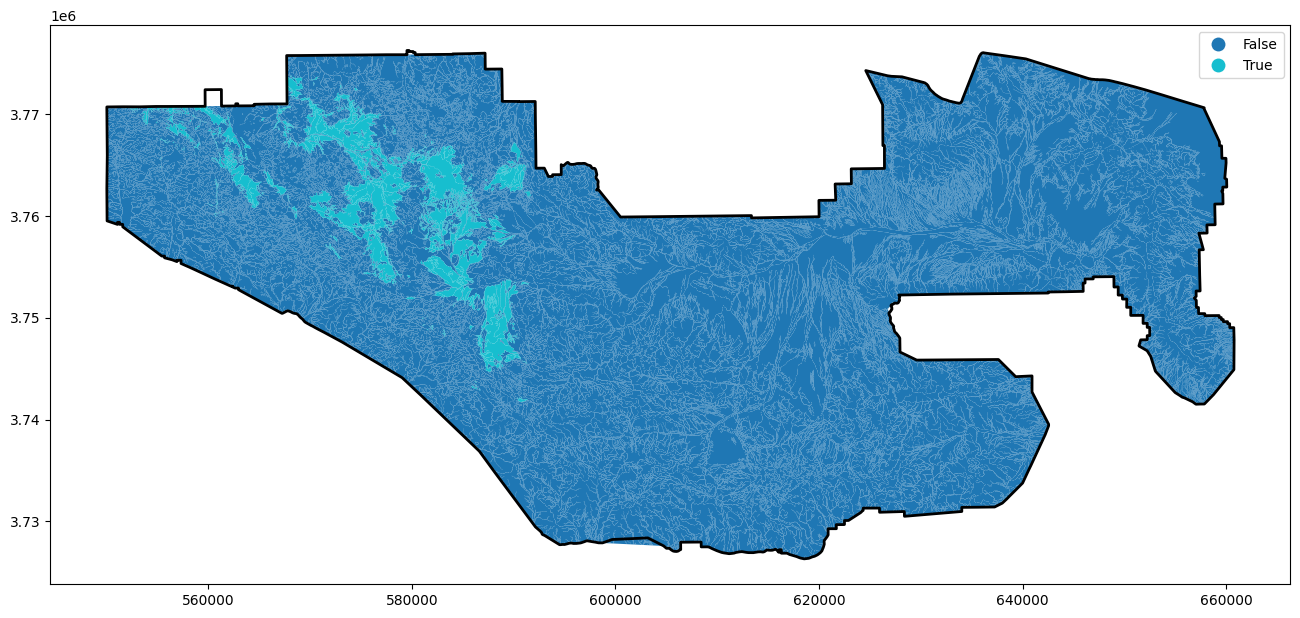

In [47]:
veg_poly.plot(column="contains_Joshua_Tree", legend=True)
park_boundary.plot(color="none", edgecolor="black", linewidth=2, ax=plt.gca())